In [4]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import mat73
import scipy.stats as spst
from IPython.display import display as disp, HTML
from tqdm import tqdm
import pandas as pd
import pingouin as pg
import matplotlib.transforms as mtrans
from matplotlib.colors import rgb2hex
from pandas.plotting import table
from blab.itertools import true_meshgrid
from blab.tables import get_MANOVA_table, get_RM_ANOVA_table
from blab.plotting import transform_same_lines
from numpy import ma
from sklearn.neighbors import KernelDensity
# import torch as tr
from glob import glob
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

from matplotlib.backends.backend_pdf import PdfPages

%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [5]:
import scipy.io as spio

def _loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    ks = '__header__', '__version__', '__globals__'
    for k in ks:
        data.pop(k)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
        elif isinstance(dict[key], np.ndarray):
            for ind, obj in enumerate(dict[key]):
                dict[key][ind] = _todict(obj)
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def loadmat(fname):
    try:
        return mat73.loadmat(fname)
    except TypeError:
        return _loadmat(fname)

def _redefine(struct):
    struct['label'] = np.squeeze(struct['label']).tolist()
    time = struct['time']
    trial = struct['trial']
    lens = [t.shape[0] for t in time]
    minlen = min(lens)
    for ind, (ti, tr) in enumerate(zip(time, trial)):
        struct['trial'][ind] = tr[..., :minlen]
        struct['time'][ind] = ti[:minlen]
    struct['time'] = np.array(np.array(struct['time']).tolist(), dtype=np.float64)
    struct['trial'] = np.array(np.array(struct['trial']).tolist(), dtype=np.float64)

def recursive_redefine(struct):
    if isinstance(struct, list) or isinstance(struct, np.ndarray):
        for obj in struct:
            recursive_redefine(obj)
    if isinstance(struct, dict):
        if (struct.get('trial') is not None) and (struct.get('time') is not None) and (struct.get('fsample') is not None):
            if isinstance(struct['time'], list):
                _redefine(struct)
            elif struct['trial'].dtype == np.object:
                _redefine(struct)
            
            if len(struct['trial'].shape) == 2:
                struct['trial'] = struct['trial'][np.newaxis, :, :]
            
            if len(struct['time'].shape) == 1:
                struct['time'] = np.tile(struct['time'], (struct['trial'].shape[0], 1))

        else:
            for k, v in struct.items():
                recursive_redefine(v)
    
def save_masked(name, arr):
    temp = np.array(arr)
    temp[arr.mask] *= np.nan
    np.save(name, temp)
    
def load_masked(name):
    temp = np.load(name)
    return ma.array(temp, mask=np.isnan(temp))

def norm(a):
    return (a - np.nanmin(a))/(np.nanmax(a) - np.nanmin(a))
    
def local_mins(sig):
    sig_len = sig.shape[-1]
    local_min_points_mask = np.diff((np.diff(sig) < 0).astype(int)) < 0
    local_min_points_inds = np.r_[2:sig_len][local_min_points_mask]
    local_min_points_values = sig[local_min_points_inds]
    return local_min_points_inds, local_min_points_values

def local_maxes(sig):
    sig_len = sig.shape[-1]
    local_min_points_mask = np.diff((np.diff(sig) < 0).astype(int)) > 0
    local_min_points_inds = np.r_[2:sig_len][local_min_points_mask]
    local_min_points_values = sig[local_min_points_inds]
    return local_min_points_inds, local_min_points_values

import itertools

def create_shape(obj, hard=False):
    if hasattr(obj, '__len__'):
        if len(obj) == 0:
            return [0]
        if not hard:
            if not hasattr(obj[0], '__len__'):
                return [len(obj)]
        lens = [create_shape(i) for i in obj]
        pure_lens = [i for i in lens if i is not None]
        depths = []
        if len(pure_lens) != 0:
            depths = np.array(list(itertools.zip_longest(*pure_lens, fillvalue=0))).max(axis=-1).tolist()
        obj_len = len(obj)
        temp = [len(obj)] + depths
        return [i for i in temp if i != 0]
    
def marray_from_lists(obj):
    shape = np.array(create_shape(obj))
#     print(shape)
    ndims = len(shape)
    if ndims == 1:
        return ma.array(obj)
    else:
        return _marray_from_lists(obj, shape, 0)
    
def _marray_from_lists(obj, shape, depth):
    ndims = len(shape)
    if depth == ndims - 1:
        if hasattr(obj, '__len__'):
            pass # для учтения кейса
        else:
            if obj is not None:
                obj = [obj]
            else:
                temp = ma.empty(shape[depth])
                temp.mask = True
                return temp
        ntrail = shape[depth] - len(obj)
        trail = ma.empty(ntrail)
        trail.mask = True
        temp = ma.array(obj)
        return ma.concatenate((obj, trail))
    else:
        if not hasattr(obj, '__len__'):
            temp = ma.empty(shape[depth:])
            if obj is not None:
                mask = np.ones(shape[depth:]).flatten()
                temp = ma.empty(shape[depth:]).flatten()
                mask[0] = 0
                temp[0] = obj
                temp.mask = mask
                temp = temp.reshape(shape[depth:])
            else:
                temp.mask = True
            return temp
        else:
            trail_shape = shape[depth:].copy()
            trail_shape[0] -= len(obj)
#             print(trail_shape, shape)
            trail = ma.empty(trail_shape)
            trail.mask = True
            temp = ma.stack([_marray_from_lists(i, shape, depth + 1) for i in obj])
            temp = ma.concatenate((temp, trail))
            return temp
        
def allbut(*names, levels):
    names = set(names)
    return [item for item in levels if item not in names]

def plot_jasp(data, x, line=None, plots=None, errors=True, var=None, kind='line', sharey=False):
    if plots is not None:
        ngroups = data.groupby(plots).ngroups
        cols = int(np.sqrt(ngroups))
        rows = int(np.ceil(ngroups/cols))
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6.4*cols, 4.8*rows))
        axes = np.array(axes).flatten().tolist()
        for (group_name, group), ax in zip(data.groupby(plots), axes):
            group_name = [group_name] if not isinstance(group_name, tuple) else group_name
            plots_list = [plots] if not hasattr(plots, '__iter__') else plots
#             print(plots_list, group_name)
            title = '; '.join([': '.join(i) for i in zip(plots_list, group_name)])
#             disp(group)
            _plot_jasp(group, x, line, title, ax=ax, errors=errors, kind=kind, sharey=sharey, var=var)
    else:
        fig, ax = plt.subplots(1, 1)
        _plot_jasp(data, x, line, ax=ax, var=var)
    return fig
    
    
def _plot_jasp(data, x, line=None, title=None, subplots=False, ax=None, errors=True, kind='line', sharey=False, var=None):
    groups = [x]
    groups.append(line) if line is not None else None
    means = data.groupby(groups).mean().unstack(level=x).T.droplevel(0)
    errors = data.groupby(groups).sem().unstack(level=x).T.droplevel(0) if errors else None
    kwargs = {}
    if errors is not None:
        kwargs['capsize'] = 8
    ax = means.plot(kind=kind, yerr=errors, title=title, ax=ax, sharey=sharey, **kwargs)
    xticks = list(means.index)
#     print(xticks)
    if len(xticks) == 2:
        ticks = ax.get_xticklabels()
#         print(ticks)
        ticks[-2].set_text(xticks[-1])
        ax.set_xticklabels(ticks)
#     print()
    ax.grid()
    fig = ax.figure
    transform_same_lines(ax, fig, 10) if kind =='line' else None

# Pack TMS data

In [7]:
cases = ['right_im1', 'right_im2', 'right_real', 'right_quasi']
bgr_case = 'right_real'

data = mat73.loadmat('motor_imagery/preproc_data.mat')
res = data['res']
res_bgr = data['res_bgr']

labels_after = np.array(res[0]['right_real']['label']).T[0].tolist()
# mask = np.sum(np.array([np.array(labels) == i for i in picks]), axis=0).astype(bool)

data_arrays_after = []
bgr_data_arrays_after = marray_from_lists([j[bgr_case]['trial'] if j is not None else None for j in res_bgr])
for case in tqdm(cases):
    temp = marray_from_lists([j[case]['trial'] if j is not None else None for j in res])[..., :9500]
    data_arrays_after.append(temp)

data_arrays_after = ma.stack(data_arrays_after)
plug = ma.empty(data_arrays_after.shape)
plug.mask = True
data_arrays_after = ma.concatenate([data_arrays_after, plug])



100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.31s/it]


In [8]:
cases = ['right_im1', 'right_im2', 'right_real', 'right_quasi', 'left_im1', 'left_im2', 'left_real', 'left_quasi']
bgr_case = 'right_real'

data = mat73.loadmat('motor_imagery/sub_all.mat')
data_bgr = loadmat('motor_imagery/sub_all_bgr.mat')

res = data['subs_ica']
res_bgr = data_bgr['subs_ica_bgr'].tolist()

# res[9] = None
# res_bgr[9] = None


labels_before = np.array(res[0]['right_real']['label']).T[0].tolist()
# mask = np.sum(np.array([np.array(labels) == i for i in picks]), axis=0).astype(bool)

data_arrays_before = []
bgr_data_arrays_before = marray_from_lists([j[bgr_case]['trial'] if j is not None else None for j in res_bgr])

for case in tqdm(cases):
    temp = marray_from_lists([j[case]['trial'] if j is not None else None for j in res])[..., :9500]
    data_arrays_before.append(temp)

data_arrays_before = ma.stack(data_arrays_before)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:35<00:00,  4.46s/it]


In [16]:
data_arrays = ma.stack([data_arrays_before, data_arrays_after])
bgr_data_array = ma.stack([bgr_data_arrays_before[:, None, ...], bgr_data_arrays_after])

data_arrays_arr_bgr = np.array(bgr_data_array)
data_arrays_arr_bgr[bgr_data_array.mask] *= np.nan
np.save('TMS_RAW_DATASET_BGR.npy', data_arrays_arr_bgr)


data_arrays_arr = np.array(data_arrays)
data_arrays_arr[data_arrays.mask] *= np.nan
np.save('TMS_RAW_DATASET.npy', data_arrays_arr)

In [11]:
picks = ['C3', 'C4', 'F3', 'F4']
mask = np.sum(np.array([np.array(channel_labels) == i for i in picks]), axis=0).astype(bool)
freqs = np.r_[5:30:0.4]
tfr = []
tfr_bgr = []

theta = (freqs < 8)* (freqs >= 5)
alpha = (freqs < 14)* (freqs >= 8)
beta = (freqs < 30)* (freqs >= 15)

days = np.r_[:2]
cases = np.r_[:8]
subjects = np.r_[:15]

data_cases = true_meshgrid(days, cases, subjects)
bgr_cases = true_meshgrid(days, subjects)

for data_case in tqdm(data_cases):
    slice_index = np.ix_(*data_case[:, None])
    temp = np.squeeze(data_arrays[slice_index][..., 0:-1:4][..., mask, :])
    sh = np.ones(len(temp.mask.shape) + 1, dtype=int).tolist()
    sh[-2] = len(freqs)
    nanmask = np.tile(temp.mask[..., None, :], sh)
    if not np.all(temp.mask):   
        temp = mne.time_frequency.tfr_array_morlet(temp, 250, freqs, freqs, output='power', n_jobs=10, verbose=False, )
        temp = ma.array(temp, mask=nanmask)
    else:
        temp = ma.empty(nanmask.shape)
        temp.mask = True    
    theta_data = temp[..., theta, :].mean(axis=-2)
    alpha_data = temp[..., alpha, :].mean(axis=-2)
    beta_data = temp[..., beta, :].mean(axis=-2)
    temp = ma.stack([theta_data, alpha_data, beta_data], axis=-2)
    tfr.append(temp)

for bgr_case in tqdm(bgr_cases):
    slice_index = np.ix_(*bgr_case[:, None])
    temp = np.squeeze(bgr_data_array[slice_index][..., 0:-1:4][..., mask, :])[None, ...]
    sh = np.ones(len(temp.mask.shape) + 1, dtype=int).tolist()
    sh[-2] = len(freqs)
    nanmask = np.tile(temp.mask[..., None, :], sh)
    temp = mne.time_frequency.tfr_array_morlet(temp, 250, freqs, freqs, output='power', n_jobs=10, verbose=False)
    temp = ma.array(temp, mask=nanmask)
    
    theta_data = temp[..., theta, :].mean(axis=-2)
    alpha_data = temp[..., alpha, :].mean(axis=-2)
    beta_data = temp[..., beta, :].mean(axis=-2)
    temp = ma.stack([theta_data, alpha_data, beta_data], axis=-2)
    tfr_bgr.append(temp)


tfr_arr = ma.stack(tfr)
tfr_bgr_arr = ma.stack(tfr_bgr)

tfr_shape = [2, 8, 15] + list(tfr_arr.shape)[1:]
bgr_shape = [2, 15] + list(tfr_bgr_arr.shape)[1:]
tfr_arr = tfr_arr.reshape(tfr_shape)[..., 250:250*9]
tfr_bgr_arr = tfr_bgr_arr.reshape(bgr_shape)[:, None, ..., 250:-250].mean(axis=-1, keepdims=True)

tfr_arr = (tfr_arr - tfr_bgr_arr)/tfr_bgr_arr
tfr_arr = np.rollaxis(tfr_arr, 3, -1)
tfr_arr = np.rollaxis(tfr_arr, 2, 5)

100%|████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.52it/s]


In [ ]:
save_masked('TMS_TFR_PROCESSED.npy', tfr_arr)

# Load data

In [3]:
data_arrays = load_masked('../tfr_stat/data/TMS_RAW_DATASET.npy')
bgr_data_array = load_masked('../tfr_stat/data/TMS_RAW_DATASET_BGR.npy')

KeyboardInterrupt: 

In [6]:
data_bgr = loadmat('../data/sub_all_bgr.mat')
channel_labels = np.array(data_bgr['subs_ica_bgr'][0]['right_real']['label'].tolist())
del data_bgr

In [16]:
channel_labels

array(['FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT9', 'FC5', 'FC1',
       'FC2', 'FC6', 'FT10', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5',
       'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1',
       'Oz', 'O2'], dtype='<U4')

In [7]:
tfr_arr = load_masked('../tfr_stat/data/TMS_TFR_PROCESSED.npy')
time = np.r_[1:9:0.004]

# Plotting

In [ ]:
erd_table_temp = erd_table.drop(['Bilateral', 'Contralateral', 'Ipsilateral'], axis=1)
plot_jasp(erd_table_temp, '', line='Hand', plots=['Zone'], errors=False, kind='line', sharey=True);
plt.tight_layout();

In [9]:

# case = 0
# subj = 1
# band = 0
# ch = 3
def calculate_mbrt(data, threshold=1.4, block_start_th=3):
    time = np.r_[1:9:0.004]
    base = data[..., time < 5]
    post = data[..., time >= 5]
    base_mean = np.mean(base)
    post_avgovertrials = post.mean(axis=0)
    post_len = len(post_avgovertrials)
    post_time_raw = time[time >= 5] - 5
    
    
    # я взял это значение от балды, близко к 1.7, которое соответствует критическому уровню p_value = 0.05
    # почему именно 1.4 -- лучше всех подходит
#     threshold = 1.4 
    T_obs, clusters, cluster_p_values, _ = \
        mne.stats.permutation_cluster_test([base, post], n_permutations=1000,
                                 threshold=threshold, tail=1, n_jobs=10,
                                 out_type='mask', stat_fun=lambda a, b: spst.ttest_rel(a, b).statistic, verbose=False)
    raw_clusters = clusters
    
    if len(clusters) == 0:
        return None

    # берем только те кластеры, которые появляются до 8-й секунды (в первые три секунды после сигнала)
    # также не берем слишком ранние кластеры
    clusters_mask = np.array([c[0].start < post_time_raw[post_time_raw < block_start_th].shape[0]  and c[0].stop > 50  for c in clusters]) 
    clusters = [tuple(c) for c in np.array(clusters)[clusters_mask].tolist()]
    if len(clusters) == 0:
        return None
    cluster_p_values = np.array(cluster_p_values)[clusters_mask].tolist()

    # берем кластер из набора выше с минимальным p_value
#     c = clusters[np.argmin(cluster_p_values)]
    c = clusters[np.argmin(np.array([post_avgovertrials[c].mean() for c in clusters]))]
#     c = clusters[0]

    # average over trials and select points within cluster
    poststimul_cluster_selection = post.mean(axis=0)[c]

    selection_len = len(poststimul_cluster_selection)

    # finding local minimumns within cluster
    local_min_points_mask = np.diff((np.diff(poststimul_cluster_selection) < 0).astype(int)) < 0
    local_min_points_inds = np.r_[2:selection_len][local_min_points_mask]
    local_min_points_values = poststimul_cluster_selection[local_min_points_inds]

    # ищем те минимумы, которые не сильно отличаются от средней минимумов (нужно для выбора первой точки, если вышло плато и точка выбирается в конце)
    # то есть грубо говоря, если локальные минимумы находятся примерно на одном уровне, то останутся все.
    # если же есть минимум который сильно выше, то он откидывается.
    # не учитывается случай, если несколько высоких локальных минимумов и один с сильной просадкой
    local_min_points_mean = local_min_points_values.mean()
    mask = np.abs(local_min_points_values/local_min_points_mean - 1) < 0.05
    local_min_points_inds = local_min_points_inds[mask]


    if local_min_points_inds.shape == (0, ):
        # на случай, если локальных минимумов вообще нет
        min_point = np.argmin(poststimul_cluster_selection)
    else:
        min_point = local_min_points_inds[0]
    
    result_point_ind = np.r_[0:post_len][c][min_point]
    result_point = post_avgovertrials[result_point_ind]
    result_point_ind = len(time[time < 5]) + result_point_ind
    
    delta_e = base_mean - result_point
    delta_t = time[result_point_ind] - 5
    result = {}
    result['delta_t'] = delta_t
    result['delta_e'] = delta_e
    result['point_ind'] = result_point_ind
    result['cluster_slice'] = c
    result['raw_clusters'] = raw_clusters
    result['clusters'] = clusters
    return result
    

In [23]:
# mbrt_MA_temp = np.rollaxis(tfr_arr, 2).reshape(4, 2, 2, 4, 3, 15, 20, 2000)
# Left_side = (mbrt_MA_temp[0:3:2, ..., 1000:1500]).mean(axis=-1)
# Right_side = (mbrt_MA_temp[1:4:2, ..., 1000:1500]).mean(axis=-1)
mbrt_MA_temp = np.rollaxis(mbrt_MA_all_first, 2).reshape(4, 2, 2, 4, 3, 15, 20, 2)
Left_side = mbrt_MA_temp[0:3:2, ..., 0]
Right_side = mbrt_MA_temp[1:4:2, ..., 0]

Prop = Right_side/Left_side
# Prop = 1/Prop

data_mask = Left_side.mask

threshold = 0.05

contralateral_mask = (Prop - 1) < -threshold
contralateral_mask.mask = data_mask

ipsilateral_mask = (Prop - 1) > threshold
ipsilateral_mask.mask = data_mask

bilateral_mask = (-threshold <= (Prop - 1)) & ((Prop - 1) <= threshold)
bilateral_mask.mask = data_mask

Left_side_mask = ~np.isnan(Left_side)
Right_side_mask = ~np.isnan(Right_side)


bi_start = (Left_side_mask & Right_side_mask)
bi = (bi_start & bilateral_mask)
contr = ~(~Left_side_mask | Right_side_mask) | (bi_start & contralateral_mask)
ipsi = ~(~Right_side_mask | Left_side_mask) | (bi_start & ipsilateral_mask)

none = ~(bi | contr | ipsi)


bi = bi.astype(float)
contr = contr.astype(float)
ipsi = ipsi.astype(float)
none = none.astype(float)
# bi_contr_prop = (bi + contr)/ma.stack([bi, contr, ipsi], axis=-1).sum(axis=-1)

erd_cases = np.swapaxes(ma.stack([bi, contr, ipsi, none], axis=-1), 5, 6)
variables = ['Bilateral', 'Contralateral', 'Ipsilateral', 'None']
facs = {'Zone': ['Motor', 'Premotor'], 'Day': ['1', '2'], 'Hand': ['Right','Left'], 'Session': ['Im1', 'Im2', 'Real', 'Quasi'], 'Band':['Theta', 'Alpha', 'Beta'], 'Trial':range(1, 21)}


erd_table = get_MANOVA_table(erd_cases, 6, facs, variables)
erd_table['Bi + Contr Proportion'] = (erd_table['Bilateral'] + erd_table['Contralateral'])/(erd_table['Bilateral'] + erd_table['Contralateral'] + erd_table['Ipsilateral'])
erd_agg = erd_table.groupby(['Zone', 'Hand', 'Session', 'Band']).mean().query('Band == "Alpha"')
# erd_agg['Bi + Contr Proportion'] = (erd_agg['Bilateral'] + erd_agg['Contralateral'])/(erd_agg['Bilateral'] + erd_agg['Contralateral'] + erd_agg['Ipsilateral'])
erd_agg *= 100
erd_agg = erd_agg.round()
erd_agg = erd_agg.droplevel(3)
erd_agg = erd_agg.reorder_levels([1, 0, 2])
erd_agg = erd_agg.sort_index()
erd_agg
# erd_cases = np.rollaxis(erd_cases, 0, len(erd_cases.shape))

NameError: name 'mbrt_MA_all_first' is not defined

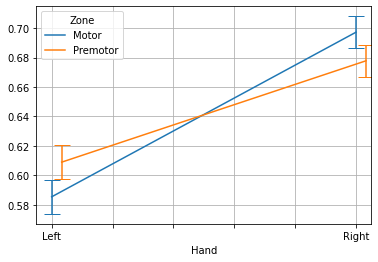

In [60]:
plot_jasp(erd_table.query('Session == "Real"')[['Subject', 'Zone', 'Day', 'Hand', 'Session', 'Band', 'Trial',
       'Bi + Contr Proportion']], 'Hand', line='Zone');

In [210]:
# mbrt_MA_temp = np.rollaxis(tfr_arr, 2).reshape(4, 2, 2, 4, 3, 15, 20, 2000)
# Left_side = np.min(tfr_data[0:3:2, ...], axis=-1)
# Right_side = np.min(tfr_data[1:4:2, ...], axis=-1)
# mbrt_MA_temp = np.rollaxis(mbrt_MA_all, 2).reshape(4, 2, 2, 4, 3, 15, 20, 2)
Left_side = mbrt_MA_all[0:3:2, ..., 0]
Right_side = mbrt_MA_all[1:4:2, ..., 0]

Prop = Right_side/Left_side
Prop = 1/Prop

data_mask = Left_side.mask

threshold = 0.1

contralateral_mask = (Prop - 1) < -threshold
contralateral_mask.mask = data_mask

ipsilateral_mask = (Prop - 1) > threshold
ipsilateral_mask.mask = data_mask

bilateral_mask = (-threshold <= (Prop - 1)) & ((Prop - 1) <= threshold)
bilateral_mask.mask = data_mask

Left_side_mask = ~np.isnan(Left_side)
Right_side_mask = ~np.isnan(Right_side)


bi_start = (Left_side_mask & Right_side_mask)
bi = (bi_start & bilateral_mask)
contr = ~(~Left_side_mask | Right_side_mask) | (bi_start & contralateral_mask)
ipsi = ~(~Right_side_mask | Left_side_mask) | (bi_start & ipsilateral_mask)

none = ~(bi | contr | ipsi)


bi = bi.astype(float)
contr = contr.astype(float)
ipsi = ipsi.astype(float)
none = none.astype(float)
# bi_contr_prop = (bi + contr)/ma.stack([bi, contr, ipsi], axis=-1).sum(axis=-1)

erd_cases = np.swapaxes(ma.stack([bi, contr, ipsi, none], axis=-1), -2, -3)
variables = ['Bilateral', 'Contralateral', 'Ipsilateral', 'None']
facs = {'Zone': ['Motor', 'Premotor'], 'Group': ['EA', 'YA'], 'Hand': ['Right','Left'], 'Band':['Theta', 'Alpha', 'Beta'], 'Trial':range(1, 31)}


erd_table = get_MANOVA_table(erd_cases, 5, facs, variables)
erd_table['Bi + Contr Proportion'] = (erd_table['Bilateral'] + erd_table['Contralateral'])/(erd_table['Bilateral'] + erd_table['Contralateral'] + erd_table['Ipsilateral'])
erd_agg = erd_table.groupby(['Zone', 'Group', 'Hand', 'Band']).mean().query('Band == "Alpha"')
# erd_agg['Bi + Contr Proportion'] = (erd_agg['Bilateral'] + erd_agg['Contralateral'])/(erd_agg['Bilateral'] + erd_agg['Contralateral'] + erd_agg['Ipsilateral'])
erd_agg *= 100
erd_agg = erd_agg.round()
erd_agg = erd_agg.droplevel(3)
erd_agg = erd_agg.reorder_levels([1, 0, 2])
erd_agg = erd_agg.sort_index()
erd_agg
# erd_cases = np.rollaxis(erd_cases, 0, len(erd_cases.shape))

Bilateral  Contralateral  Ipsilateral  None  \
Group Zone     Hand                                                 
EA    Motor    Left        55.0           24.0         21.0   0.0   
               Right       53.0           22.0         25.0   0.0   
      Premotor Left        47.0           23.0         30.0   0.0   
               Right       44.0           25.0         32.0   0.0   
YA    Motor    Left        59.0           22.0         18.0   0.0   
               Right       61.0           19.0         20.0   0.0   
      Premotor Left        50.0           22.0         28.0   0.0   
               Right       49.0           25.0         26.0   0.0   

                      Bi + Contr Proportion  
Group Zone     Hand                          
EA    Motor    Left                    79.0  
               Right                   75.0  
      Premotor Left                    70.0  
               Right                   68.0  
YA    Motor    Left                    82.0  
               Right                   80.0  
      Premotor Left                    72.0  
               Right                   74.0

In [689]:
from scipy import stats

a = tfr_data[0, 0, 0, 1, sub, :, :375]

b = tfr_data[0, 0, 0, 1, sub, :, 375:375 + 375]

f_thresh = stats.t.ppf(0.025, 29)

mean = tfr_data[0, 0, 0, 1, sub, ...].mean(axis=-1).min(axis=-1)

def stat_fun(*args):
#     print(args[0].shape)
    temp = stats.ttest_rel(*args, axis=0).statistic
#     print(temp.shape)
    return temp
sub = 0
a = tfr_data[0, 0, 0, 1, sub, :, :375]

b = tfr_data[0, 0, 0, 1, sub, :, 375:]

T_obs, clusters, cluster_p_values, H0  = mne.stats.permutation_cluster_test([b, a], n_permutations=10000,
                         threshold=f_thresh, tail=-1, n_jobs=10,
                         out_type='mask', stat_fun=stat_fun)
sortinds = np.argsort(cluster_p_values)
cluster_p_values = cluster_p_values[sortinds]
clusters = np.array(clusters)[sortinds]
print(cluster_p_values)

ValueError: All samples mush have the same size

In [405]:
# times = ma.min(ma.stack( [mbrt_MA_temp[0:3:2, ..., 1], mbrt_MA_temp[1:4:2, ..., 1]], axis=-1), axis=-1)

times = ma.max(ma.stack( [mbrt_MA_temp[0:3:2, ..., 1], mbrt_MA_temp[1:4:2, ..., 1]], axis=-1), axis=-1, keepdims=True)
print(times.shape)
times = np.tile(times, [2] + [1]*(times.ndim - 2) + [2000])
times[[0, 1, 2, 3]] = times[[0, 2, 1, 3]]
print(times.shape)
times_tile = np.tile(time.reshape( *([1]*(times.ndim - 1) + [-1]) ), list(times.shape[:-1]) + [1])
erd_mask = (times == times_tile).reshape(-1, 2000)
for i in range(erd_mask.shape[0]):
    if np.all(erd_mask[i].mask):
        erd_mask[i].mask &= False
        erd_mask[i] &= False
        erd_mask[i][0] = True
erd_mask = erd_mask.reshape(*times.shape)
tfr_arr_norm = np.rollaxis(tfr_arr, 2, 6).reshape(-1, 4000)
tfr_arr_norm_min = tfr_arr_norm.min(axis=-1, keepdims=True)
tfr_arr_norm_max = tfr_arr_norm.max(axis=-1, keepdims=True)
tfr_arr_norm = (tfr_arr_norm - tfr_arr_norm_min)/(tfr_arr_norm_max - tfr_arr_norm_min)
tfr_arr_norm = np.rollaxis(tfr_arr_norm.reshape(2, 2, 4, 3, 15, 20, 4, 2000), 6)
mbrt = tfr_arr_norm[erd_mask].reshape(*times.shape[:-1])
# mbrt = tfr_arr.reshape(2, 2, )[erd_mask]

(2, 2, 2, 4, 3, 15, 20, 1)
(4, 2, 2, 4, 3, 15, 20, 2000)


In [33]:
# mbrt_MA_temp = np.rollaxis(mbrt_MA_all_first, 2).reshape(4, 2, 2, 4, 3, 15, 20, 2)
# times = ma.max(ma.stack( [mbrt_MA_temp[0:3:2, ..., 1], mbrt_MA_temp[1:4:2, ..., 1]], axis=-1), axis=-1)
# times = np.tile(times, [1]*times.ndims + [2000])
# times_tile = np.tile(time.reshape( *([1]*times.ndims + [-1]) ), list(times.shape[:-1]) + [1])
Left_side = mbrt[0:3:2, ...]
Right_side = mbrt[1:4:2, ...]


Prop = Left_side - Right_side
Prop = -Prop

data_mask = Left_side.mask

threshold = 0.01

contralateral_mask = Prop > threshold
contralateral_mask.mask = data_mask

ipsilateral_mask = Prop < -threshold
ipsilateral_mask.mask = data_mask

bilateral_mask = (-threshold <= Prop) & ( Prop <= threshold)
bilateral_mask.mask = data_mask

# Left_side_mask = ~np.isnan(Left_side)
# Right_side_mask = ~np.isnan(Right_side)

bi = bilateral_mask
contr = contralateral_mask
ipsi = ipsilateral_mask

# none = ~(bi | contr | ipsi)

bi = bi.astype(float)
contr = contr.astype(float)
ipsi = ipsi.astype(float)
none = none.astype(float)

erd_cases = np.swapaxes(ma.stack([contr, ipsi, bi], axis=-1), 5, 6)
variables = ['Contralateral', 'Ipsilateral', 'Bilateral']
facs = {'Zone': ['Motor', 'Premotor'], 'Day': ['1', '2'], 'Hand': ['Right','Left'], 'Session': ['Im1', 'Im2', 'Real', 'Quasi'], 'Band':['Theta', 'Alpha', 'Beta'], 'Trial':range(1, 21)}


erd_table = get_MANOVA_table(erd_cases, 6, facs, variables)
erd_table['Bi + Contr Proportion'] = (erd_table['Contralateral'])/(erd_table['Contralateral'] + erd_table['Ipsilateral'])
erd_agg = erd_table.groupby(['Zone', 'Hand', 'Session', 'Band']).mean().query('Band == "Alpha"')
# erd_agg['Bi + Contr Proportion'] = (erd_agg['Bilateral'] + erd_agg['Contralateral'])/(erd_agg['Bilateral'] + erd_agg['Contralateral'] + erd_agg['Ipsilateral'])
erd_agg *= 100
erd_agg = erd_agg.round()
erd_agg = erd_agg.droplevel(3)
erd_agg = erd_agg.reorder_levels([1, 0, 2])
erd_agg = erd_agg.sort_index()
erd_agg

NameError: name 'mbrt' is not defined

In [46]:
mbrt_KDE_all_first.shape

(2, 8, 4, 3, 15, 20, 2)

In [63]:
# mbrt_MA_temp = np.rollaxis(tfr_arr, 2).reshape(4, 2, 2, 4, 3, 15, 20, 2000)
# Left_side = (mbrt_MA_temp[0:3:2, ..., 1000:1500]).mean(axis=-1)
# Right_side = (mbrt_MA_temp[1:4:2, ..., 1000:1500]).mean(axis=-1)
mbrt_MA_temp = np.rollaxis(mbrt_MA_all_mean, 2).reshape(4, 2, 2, 4, 3, 15, 20, 2)
# mbrt_MA_temp = np.rollaxis(mbrt_KDE_all_first, 2).reshape(4, 2, 2, 4, 3, 15, 20)[..., None]
Left_side = mbrt_MA_temp[0:3:2, ..., 0]
Right_side = mbrt_MA_temp[1:4:2, ..., 0]

Prop = Right_side/Left_side
# Prop = 1/Prop

data_mask = Left_side.mask

threshold = 0.1

contralateral_mask = (Prop - 1) < -threshold
contralateral_mask.mask = data_mask

ipsilateral_mask = (Prop - 1) > threshold
ipsilateral_mask.mask = data_mask

bilateral_mask = (-threshold <= (Prop - 1)) & ((Prop - 1) <= threshold)
bilateral_mask.mask = data_mask

Left_side_mask = ~np.isnan(Left_side)
Right_side_mask = ~np.isnan(Right_side)


bi_start = (Left_side_mask & Right_side_mask)
bi = (bi_start & bilateral_mask)
contr = ~(~Left_side_mask | Right_side_mask) | (bi_start & contralateral_mask)
ipsi = ~(~Right_side_mask | Left_side_mask) | (bi_start & ipsilateral_mask)

none = ~(bi | contr | ipsi)


bi = bi.astype(float)
contr = contr.astype(float)
ipsi = ipsi.astype(float)
none = none.astype(float)
# bi_contr_prop = (bi + contr)/ma.stack([bi, contr, ipsi], axis=-1).sum(axis=-1)

erd_cases = np.swapaxes(ma.stack([bi, contr, ipsi, none], axis=-1), 5, 6)
variables = ['Bilateral', 'Contralateral', 'Ipsilateral', 'None']
facs = {'Zone': ['Motor', 'Premotor'], 'Day': ['1', '2'], 'Hand': ['Right','Left'], 'Session': ['Im1', 'Im2', 'Real', 'Quasi'], 'Band':['Theta', 'Alpha', 'Beta'], 'Trial':range(1, 21)}


erd_table = get_MANOVA_table(erd_cases, 6, facs, variables)

# swap contralateral and ipsilateral column for left hand, since mask is swapped due to my stupidity
temp = erd_table.query('Hand == "Left"')
temp['Contralateral'], temp['Ipsilateral'] = temp['Ipsilateral'], temp['Contralateral']
erd_table = pd.concat([erd_table_new.query('Hand == "Right"'), temp])

erd_table['Bi + Contr Proportion'] = (erd_table['Bilateral'] + erd_table['Contralateral'])/(erd_table['Bilateral'] + erd_table['Contralateral'] + erd_table['Ipsilateral'])
erd_agg = erd_table.groupby(['Zone', 'Hand', 'Session', 'Band']).mean().query('Band == "Alpha"')
# erd_agg['Bi + Contr Proportion'] = (erd_agg['Bilateral'] + erd_agg['Contralateral'])/(erd_agg['Bilateral'] + erd_agg['Contralateral'] + erd_agg['Ipsilateral'])
erd_agg *= 100
erd_agg = erd_agg.round()
erd_agg = erd_agg.droplevel(3)
erd_agg = erd_agg.reorder_levels([1, 0, 2])
erd_agg = erd_agg.sort_index()
erd_agg
# erd_cases = np.rollaxis(erd_cases, 0, len(erd_cases.shape))

Bilateral  Contralateral  Ipsilateral  None  \
Hand  Zone     Session                                                
Left  Motor    Im1           52.0           25.0         25.0   1.0   
               Im2           50.0           25.0         25.0   0.0   
               Quasi         54.0           25.0         25.0   1.0   
               Real          61.0           24.0         24.0   0.0   
      Premotor Im1           54.0           30.0         30.0   1.0   
               Im2           50.0           28.0         28.0   1.0   
               Quasi         60.0           23.0         23.0   2.0   
               Real          60.0           20.0         20.0   2.0   
Right Motor    Im1           54.0           26.0         19.0   1.0   
               Im2           55.0           25.0         18.0   1.0   
               Quasi         58.0           22.0         19.0   0.0   
               Real          64.0           21.0         14.0   0.0   
      Premotor Im1           54.0           26.0         18.0   1.0   
               Im2           54.0           25.0         21.0   1.0   
               Quasi         61.0           20.0         19.0   0.0   
               Real          69.0           15.0         15.0   0.0   

                        Bi + Contr Proportion  
Hand  Zone     Session                         
Left  Motor    Im1                       84.0  
               Im2                       83.0  
               Quasi                     84.0  
               Real                      86.0  
      Premotor Im1                       82.0  
               Im2                       82.0  
               Quasi                     86.0  
               Real                      87.0  
Right Motor    Im1                       81.0  
               Im2                       81.0  
               Quasi                     81.0  
               Real                      85.0  
      Premotor Im1                       82.0  
               Im2                       79.0  
               Quasi                     81.0  
               Real                      85.0

In [ ]:
erd_agg.to_html()

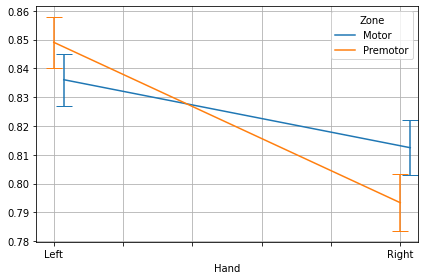

In [64]:
fig = plot_jasp(erd_table.query('Session == "Real"')[['Subject', 'Zone', 'Day', 'Hand', 'Session', 'Band', 'Trial',
       'Bi + Contr Proportion']], 'Hand', line='Zone')
fig.tight_layout()

In [65]:
fig.savefig('plots/MBRT_MA_mean_real_plot.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# MBRT Test

## Functions

### MBRT KDE

In [8]:
def shift5(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

def pick_first_group(sig, thresh):
    sas = shift5(sig<=thresh, 1).astype(int) + (sig<=thresh).astype(int)
    sas[sas == 2] *= 0
    np.cumsum(sas)

def mbrt_calc_kde(sig, bandwidth=0.15, baseline_time=2, scores_span_samples=1000, choose='biggest'):
    assert choose in ['biggest', 'first']
    
    if hasattr(sig, 'mask'):
        if np.all(sig.mask):
            temp = ma.empty(2)
            temp.mask = True
            return temp
    
    temp_time = time[time>baseline_time]
    temp = sig[time>baseline_time]
    
    X = temp[:, None]
    scores_span = np.linspace(temp.min(), temp.max(), 1000)[:, None]
    
    kde = KernelDensity(kernel='epanechnikov', bandwidth=bandwidth).fit(X)
    scores = np.exp(kde.score_samples(scores_span))
    
    inds, maxes = local_maxes(scores)
    thresh = scores_span[inds[0]]
    
    mask = temp<=thresh
    
    groups = shift5(mask, 1, False).astype(int) + (mask).astype(int)
    groups[groups == 2] *= 0
    groups = np.cumsum(groups)
    
    ngroups = groups[-1] + 1
    valid_groups = [ [i, np.sum(groups == i)] for i in range(ngroups) if np.any(mask & (groups == i) )]
#     print(np.array(valid_groups).T.shape)
    valid_groups, valid_group_sizes = np.array(valid_groups).T
    
    
    if choose == 'biggest':
        chosen_group = valid_groups[np.argmax(valid_group_sizes)]
    else:
        chosen_group = valid_groups[0]
    
    group_mask = groups == chosen_group
    
    erd_ind = np.argmin(temp[group_mask])
    erd_time = temp_time[group_mask][erd_ind]
    erd_val = temp[group_mask][erd_ind]
    
    return ma.array([erd_val, erd_time])
    

### MBRT MA

In [9]:
def mbrt_calc(trial, time, blevel=0.95, conv_num=260, b_mean=None, baseline_time=5.):
    middle = baseline_time
    if isinstance(trial, ma.core.MaskedArray):
        if np.all(trial.mask):
            return ma.array([np.nan, np.nan], mask=True)
    
    base_arr_module = ma if isinstance(trial, ma.core.MaskedArray) else np
    
#     time = np.r_[1:9:0.004]
    post_time = time[time > baseline_time]
    base_mean_level = trial[time <= baseline_time].mean() if b_mean is None else b_mean
    base_mean_level *= blevel
    
    temp_conv = np.convolve(trial, np.ones(conv_num), 'same')/conv_num
    post_conv = temp_conv[time > baseline_time]
    post_trial = trial[time > baseline_time]
    
    min_inds, min_points = local_mins(post_conv)
    
    points_mask_th = (min_inds > 20)
    
    min_inds, min_points = min_inds[points_mask_th], min_points[points_mask_th]
    test_min_points = min_points + np.abs(np.min(min_points, initial=np.nan))
    min_mean = np.mean(test_min_points)
    min_inds_mask = ( (np.abs(test_min_points/min_mean) - 1) < 0.05)

    min_inds = min_inds[min_inds_mask]
    if len(min_inds) == 0:
        argmin = np.argmin(post_trial)
    else:
        argmin = min_inds[0]
    minrange = 0.5
    p = post_time[argmin]
    p1 = p - minrange if p - minrange >= middle else middle
    p2 = p + minrange if p + minrange < time[-1] else time[-1]
    time_mask = (time >= p1) & (time <= p2)
    trial_slice = trial[time_mask]
    try:
        desync_val = np.min(trial_slice)
    except ValueError:
        print(p1, p2)
        raise ValueError('sas')
    
    if base_mean_level - desync_val < 0:
        return base_arr_module.array([np.nan, np.nan])
    
    desync_delta_time = time[time_mask][np.argmin(trial_slice)]
    
    if desync_delta_time - middle < 0.15:
        return base_arr_module.array([np.nan, np.nan])
    
    return base_arr_module.array([desync_val, desync_delta_time])

## Calc

### KDE

In [ ]:
baseline = 5.
time = np.r_[1:9:0.004]

mbrt_KDE_all = [mbrt_calc_kde(i, baseline_time=baseline) for i in tfr_arr.reshape(-1, 2000)]
mbrt_KDE_all = ma.stack(mbrt_KDE_all).reshape(*tfr_arr.shape[:-1], 2)

mbrt_KDE_all_first = [mbrt_calc_kde(i, choose='first', baseline_time=baseline) for i in tfr_arr.reshape(-1, 2000)]
mbrt_KDE_all_first = ma.stack(mbrt_KDE_all_first).reshape(*tfr_arr.shape[:-1], 2)

mbrt_KDE_mean = [mbrt_calc_kde(i, baseline_time=baseline) for i in tfr_arr.mean(axis=-2).reshape(-1, 2000)]
mbrt_KDE_mean = ma.stack(mbrt_KDE_mean).reshape(*tfr_arr.mean(axis=-2).shape[:-1], 2)

mbrt_KDE_mean_first = [mbrt_calc_kde(i, choose='first', baseline_time=baseline) for i in tfr_arr.mean(axis=-2).reshape(-1, 2000)]
mbrt_KDE_mean_first = ma.stack(mbrt_KDE_mean_first).reshape(*tfr_arr.mean(axis=-2).shape[:-1], 2)

### MA

In [ ]:
baseline = 5.
time = np.r_[1:9:0.004]

mbrt_MA_all_mean = [ma.stack([mbrt_calc(j, time, blevel=0.95, b_mean=i[:, :1000].mean()) for j in i]) for i in tfr_arr.reshape(-1, 20, 2000)]
mbrt_MA_all_mean = ma.stack(mbrt_MA_all_mean).reshape(*tfr_arr.shape[:-2], 20, 2)

mbrt_MA_all = [mbrt_calc(i, time, blevel=0.95, b_mean=i[:1000].mean()) for i in tfr_arr.reshape(-1, 2000)]
mbrt_MA_all = ma.stack(mbrt_MA_all).reshape(*tfr_arr.shape[:-1], 2)

# Y/O Dataset packing

In [5]:
from os.path import basename

def true_meshgrid(*arr):
    """
    создает из массивов условий массив комбинаций всех условий (типа [a, b], [c, d] -> [[a, c], [a, d], [b, c], [b, d]])
    """
    if len(arr) == 1:
        return np.array(arr[0])[:, None]
    return np.swapaxes(np.array(np.meshgrid(*arr)), 1, 2).reshape(len(arr), -1).T

#собирает все пути фифок в лист
filenames = glob('old_young_dataset/*')

# выделяем имя файла из полного пути
names = [basename(i).split('.')[0].split('_') for i in filenames]

# собираем все в кучу (в один нампай массив4ик)
data = []
groups = ['EA', 'YA']
hands = ['RH', 'LH']
subs = np.r_[1:11]
conds = true_meshgrid(groups, hands, subs)
for gr, hand, sub in conds:
    filename = f'old_young_dataset/{gr}_subject{sub}_{hand}_condition.epo.fif'
    #читаем фифку, вытаскиваем сами time series и в массив пихаем
    data.append(mne.read_epochs(filename, verbose=False).get_data())

# достаем названия каналов
channel_labels = np.array(mne.read_epochs(filenames[0], verbose=False).ch_names)
# красиво все организовываем
data = marray_from_lists(data).reshape(2, 2, 10, 30, 31, 2501)
#                                      G  H  S   T   C   E
# G - groups, H - hands, S - subjects, T - trials, C - channels, E - eeg signal

In [7]:
picks = ['C3', 'C4', 'F3', 'F4']


conds = true_meshgrid(np.r_[:2], np.r_[:2], np.r_[:10])
freqs = np.r_[5.:30.:.4]
theta = freqs < 8
alpha = (freqs >= 8) & (freqs <= 14)
beta = (freqs >= 15) & (freqs <= 30)
tfr_data = []
for gr, hand, sub in tqdm(conds):
    filename = f'old_young_dataset/{gr}_subject{sub}_{hand}_condition.epo.fif'
    channel_labels = np.array(mne.read_epochs(filenames[0], verbose=False).ch_names)
    mask = np.sum(np.array([channel_labels == i for i in picks]), dtype=bool, axis=0)
    temp = data[gr, hand, sub, :, :, :][..., mask, :]
    mask = np.all(temp.mask.reshape(temp.shape[0], -1), axis=-1)
    temp = mne.time_frequency.tfr_array_morlet(temp, 250, freqs, freqs, output='power', verbose=False, n_jobs=10)
    temp = ma.array(temp, mask=np.zeros(temp.shape, dtype=bool))
    temp.mask[mask] |= True
    temp = temp[..., 125:1501]
    temp = ma.stack([temp[..., theta, :].mean(axis=-2), temp[..., alpha, :].mean(axis=-2), temp[..., beta, :].mean(axis=-2)])
    bgr = temp[:376].mean(axis=-1, keepdims=True)
    temp = (temp - bgr)/bgr
    tfr_data.append(temp)

time = np.linspace(0, 10, 2501, endpoint=True)[125:1501]
tfr_data = ma.stack(tfr_data).reshape(2, 2, 10, 3, 30, 4, 1376)
tfr_data = np.rollaxis(np.swapaxes(tfr_data, -2, 2), 2)
tfr_data = np.swapaxes(tfr_data, -2, -3)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:09<00:00,  1.73s/it]


In [298]:
baseline = 2.1
time = np.linspace(0, 10, 2501, endpoint=True)[125:1501]

mbrt_MA_all = [mbrt_calc_kde(i, baseline_time=baseline) for i in tfr_data.reshape(-1, 1376)]
mbrt_MA_all = ma.stack(mbrt_MA_all).reshape(*tfr_data.shape[:-1], 2)

mbrt_MA_all_first = [mbrt_calc_kde(i, choose='first', baseline_time=baseline) for i in tfr_data.reshape(-1, 1376)]
mbrt_MA_all_first = ma.stack(mbrt_MA_all_first).reshape(*tfr_data.shape[:-1], 2)

mbrt_MA_mean = [mbrt_calc_kde(i, baseline_time=baseline) for i in tfr_data.mean(axis=-2).reshape(-1, 1376)]
mbrt_MA_mean = ma.stack(mbrt_MA_mean).reshape(*tfr_data.mean(axis=-2).shape[:-1], 2)

mbrt_MA_mean_first = [mbrt_calc_kde(i, choose='first', baseline_time=baseline) for i in tfr_data.mean(axis=-2).reshape(-1, 1376)]
mbrt_MA_mean_first = ma.stack(mbrt_MA_mean_first).reshape(*tfr_data.mean(axis=-2).shape[:-1], 2)

In [82]:
mbrt_MA_all_first.shape

(2, 8, 4, 3, 15, 20, 2)

Text(0.5, 1.0, 'Im2 Time')

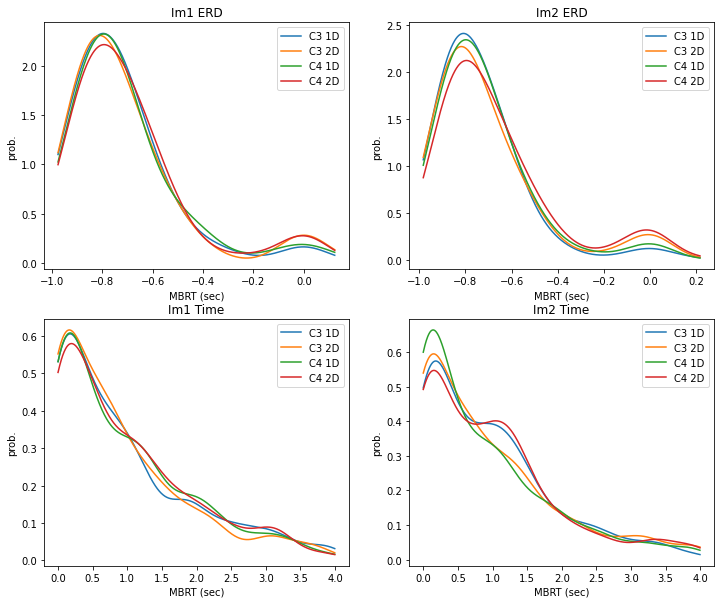

In [32]:

a, b = 0, 4


plt.figure(figsize=(12, 10))

temp = np.rollaxis(mbrt_MA_all_first, 2)

times_first = (temp[:2, :, 0, 1, ..., 0]).reshape(4, 300, 1)
scores_span = np.linspace(times_first.min(), times_first.max(), 1000)
labels = ['C3 1D', 'C3 2D', 'C4 1D', 'C4 2D']
for obj, lab in zip(times_first, labels):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(obj)
    scores = np.exp(kde.score_samples(scores_span[:, None]))
    plt.subplot(221).plot(scores_span, scores, label=lab)
    plt.legend()
    plt.xlabel('MBRT (sec)')
    plt.ylabel('prob.')
plt.title('Im1 ERD')


times_first = (temp[:2, :, 1, 1, ..., 0]).reshape(4, 300, 1)
scores_span = np.linspace(times_first.min(), times_first.max(), 1000)

for obj, lab in zip(times_first, labels):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(obj)
    scores = np.exp(kde.score_samples(scores_span[:, None]))
    plt.subplot(222).plot(scores_span, scores, label=lab)
    plt.legend()
    plt.xlabel('MBRT (sec)')
    plt.ylabel('prob.')
plt.title('Im2 ERD')


times_first = (temp[:2, :, 0, 1, ..., 1] - 5).reshape(4, 300, 1)
scores_span = np.linspace(times_first.min(), times_first.max(), 1000)

for obj, lab in zip(times_first, labels):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(obj)
    scores = np.exp(kde.score_samples(scores_span[:, None]))
    plt.subplot(223).plot(scores_span, scores, label=lab)
    plt.legend()
    plt.xlabel('MBRT (sec)')
    plt.ylabel('prob.')
plt.title('Im1 Time')


times_first = (temp[:2, :, 1, 1, ..., 1] - 5).reshape(4, 300, 1)
scores_span = np.linspace(times_first.min(), times_first.max(), 1000)

for obj, lab in zip(times_first, labels):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(obj)
    scores = np.exp(kde.score_samples(scores_span[:, None]))
    plt.subplot(224).plot(scores_span, scores, label=lab)
    plt.legend()
    plt.xlabel('MBRT (sec)')
    plt.ylabel('prob.')
plt.title('Im2 Time')

In [51]:
time

array([1.   , 1.004, 1.008, ..., 8.988, 8.992, 8.996])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


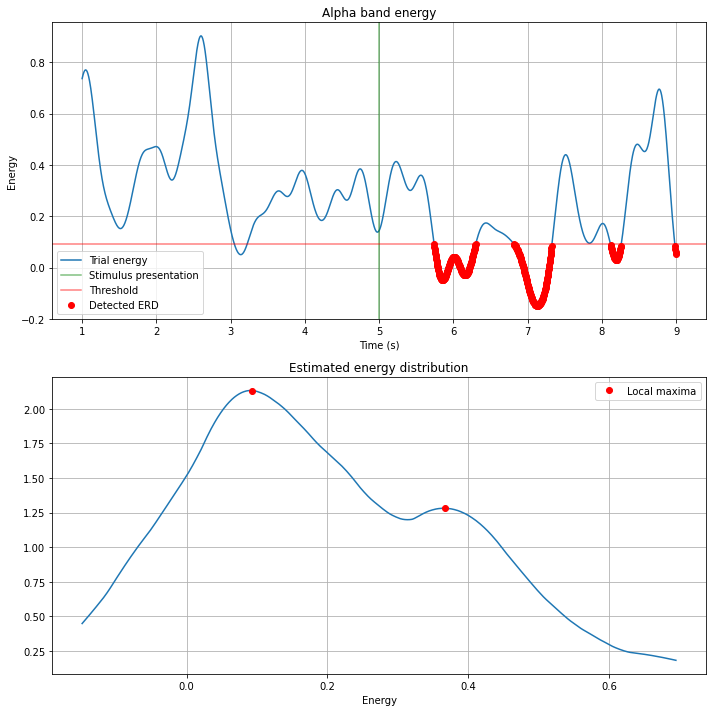

In [59]:
sub = 0
tr = 0
bins=50
temp_tr = tfr_arr[0, 2, 0, 1, sub, :, :].mean(axis=0)
time_old = time
temp = temp_tr[time_old > 5]


# a, b = np.histogram(tfr_data[0, 0, 0, 1, sub, tr, :][time > 2], bins=bins)
X = temp[:, None]
scores_span = np.linspace(temp.min(), temp.max(), 1000)[:, None]
kde = KernelDensity(kernel='epanechnikov', bandwidth=.15).fit(X)
scores = np.exp(kde.score_samples(scores_span))
inds, maxes = local_maxes(scores)
thresh = scores_span[inds[0]]
mask = (time_old > 5) & (temp_tr <= thresh)

# thresh = b[np.argmax(a)]

fig = plt.figure(figsize = (10, 10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(time_old, temp_tr, label='Trial energy')
ax1.axvline(5, color='green', alpha=0.5, label='Stimulus presentation')
ax1.axhline(thresh, color='red', alpha=0.5, label='Threshold')
ax1.plot(time_old[mask], temp_tr[mask], 'or', label='Detected ERD')
ax1.legend()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Energy')
ax1.set_title('Alpha band energy')
ax1.grid()

# ax2.hist(tfr_data[0, 0, 0, 1, sub, tr, :][time > 2], bins=bins, density=True);
ax2.plot(scores_span, scores)

ax2.plot(scores_span[inds], maxes, 'or', label='Local maxima')
ax2.set_xlabel('Energy')
ax2.legend()
ax2.set_title('Estimated energy distribution')
ax2.grid()

fig.tight_layout()
fig.savefig('plots/MBRT_KDE_example.eps')

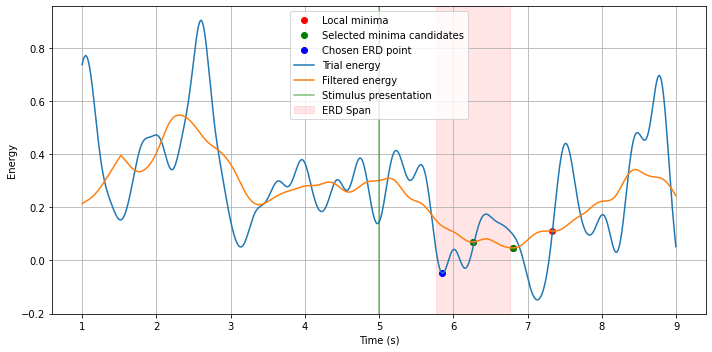

In [60]:
fig = plt.figure(figsize=(10, 5))

sub = 0
tr = 0
bins=260
b_mean = None
blevel=0.95
trial = tfr_arr[0, 2, 0, 1, sub, :, :].mean(axis=0)

baseline_time = 5.0
middle = 5.0

base_arr_module = ma if isinstance(trial, ma.core.MaskedArray) else np

post_time = time[time > baseline_time]
base_mean_level = trial[time <= baseline_time].mean() if b_mean is None else b_mean
base_mean_level *= blevel

temp_conv = np.convolve(trial, np.ones(bins), 'same')/bins
post_conv = temp_conv[time > baseline_time]
post_trial = trial[time > baseline_time]

min_inds, min_points = local_mins(post_conv)

points_mask_th = (min_inds > 20)

min_inds, min_points = min_inds[points_mask_th], min_points[points_mask_th]
plt.plot(post_time[min_inds], post_conv[min_inds], 'ro', label='Local minima')


test_min_points = min_points + np.abs(np.min(min_points))
min_mean = np.mean(test_min_points)

min_inds_mask = ( (np.abs(test_min_points/min_mean) - 1) < 0.01)
min_inds = min_inds[min_inds_mask]

plt.plot(post_time[min_inds], post_conv[min_inds], 'go', label='Selected minima candidates')

if len(min_inds) == 0:
    argmin = np.argmin(post_trial)
else:
    argmin = min_inds[0]
minrange = 0.5
p = post_time[argmin]
p1 = p - minrange if p - minrange >= middle else middle
p2 = p + minrange if p + minrange < time[-1] else time[-1]
plt.axvspan(p1, p2, color='red', alpha=0.1, label='ERD Span')
time_mask = (time >= p1) & (time <= p2)
trial_slice = trial[time_mask]

desync_delta_time = time[time_mask][np.argmin(trial_slice)]
plt.plot(time[time_mask][np.argmin(trial_slice)], trial[time_mask][np.argmin(trial_slice)], 'bo', label='Chosen ERD point')

plt.plot(time, trial, label='Trial energy')
plt.plot(time, temp_conv, label='Filtered energy')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.axvline(5, color='green', alpha=0.5, label='Stimulus presentation')
plt.legend()
plt.grid()
plt.tight_layout()
fig.savefig('plots/MBRT_MA_example.pdf')

array([], dtype=int32)

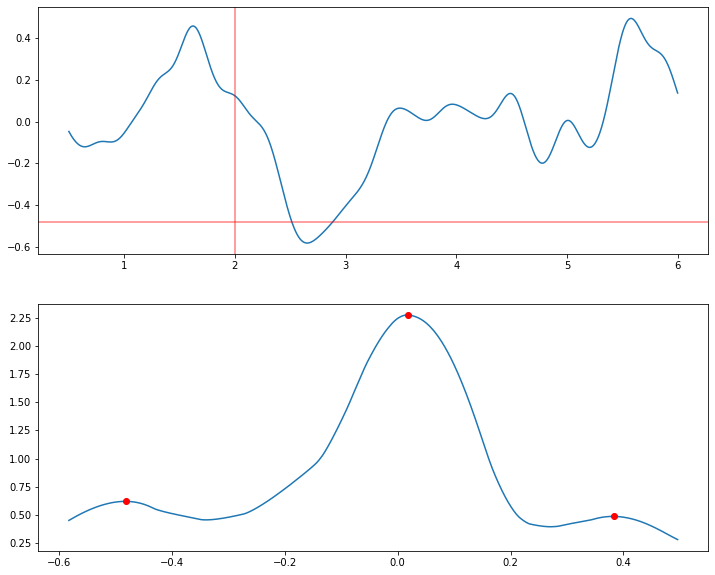

In [221]:
sub = 3
tr = 2
bins=50
temp_tr = tfr_data[0, 0, 0, 1, sub, :, :].mean(axis=0)
temp = temp_tr[time > 2]


# a, b = np.histogram(tfr_data[0, 0, 0, 1, sub, tr, :][time > 2], bins=bins)
X = temp[:, None]
scores_span = np.linspace(temp.min(), temp.max(), 1000)[:, None]
kde = KernelDensity(kernel='epanechnikov', bandwidth=.15).fit(X)
scores = np.exp(kde.score_samples(scores_span))
inds, maxes = local_maxes(scores)
thresh = scores_span[inds[0]]


# thresh = b[np.argmax(a)]

plt.figure(figsize = (12, 10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(time, temp_tr)
ax1.axhline(thresh, color='red', alpha=0.5)
ax1.axvline(2, color='red', alpha=0.5)

# ax2.hist(tfr_data[0, 0, 0, 1, sub, tr, :][time > 2], bins=bins, density=True);
ax2.plot(scores_span, scores)

ax2.plot(scores_span[inds], maxes, 'or')


In [5]:
from time import sleep

a = 5
while a > 0:
    print(a, end=' ')
    a -= 1
    sleep(0.5)


5 4 3 2 1 